# Import needed libraries

In [137]:
##pip install Augmentor 

In [138]:
##pip install tensorflow

In [139]:
import time # used to measure model training time
exp_start_time = time.time()
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import os
from skimage import io
from PIL import Image
from pathlib import Path
import Augmentor

from sklearn.metrics import confusion_matrix, classification_report, \
        ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import applications
from keras import optimizers, layers, models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, \
    Flatten, Dense, Dropout, Input, Lambda, LeakyReLU, PReLU, Activation
# import cv2
'''
from glob import glob
'''

'\nfrom glob import glob\n'

## Load Images into workspace and preprocess

In [140]:
# Read datasets from local directories as train/val/test sets
train_dir = r'C:\Amoakoh\dataset\multiclassRawDataset\train'
val_dir = r'C:\Amoakoh\dataset\multiclassRawDataset\val'
test_dir = r'C:\Amoakoh\dataset\multiclassRawDataset\test'

train_paper = r'C:\Amoakoh\dataset\multiclassRawDataset\train\paper'
val_paper = r'C:\Amoakoh\dataset\multiclassRawDataset\val\paper'
test_paper = r'C:\Amoakoh\dataset\multiclassRawDataset\test\paper'

## Set general model hyperparameters

In [141]:
img_height = 224
img_width = 224
num_channels = 3 # 3 for RGB images but 1 for grayscale images
batchSize = 128 #32, 64, 128
epochs = 5 #18
N = 0  # number of neurons in first layer of top layer
dropout_rate = 0  # 0.5 < dropout rate range < 0.8, 0 rate means no dropout
dropout_seed = 200 # optional parameter

pool_size =(2, 2) 
pool_strides =(2, 2)
kernel_size =(3, 3) 
conv2D_strides =(1, 1)

target_names = ['cardboard', 'glass','ied', 'metal','paper', 'plastic','trash']

steps_per_epoch = len(os.listdir(train_paper))//batchSize # terminates an epoch
validation_steps =  len(os.listdir(val_paper))//batchSize

kInitializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=60) # kernel initializer
bInitializer = tf.keras.initializers.TruncatedNormal(mean=0.3, stddev=0.1, seed=60) # bias initializer

import functools
#SS = tf.keras.metrics.SpecificityAtSensitivity()
#recall = tf.keras.metrics.Recall()
#accuracy = tf.keras.metrics.Accuracy()
mse = tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None)
top1_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=1)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top1_acc.__name__ = 'top1_acc'
top5_acc.__name__ = 'top5_acc'
metrics=['acc','top_k_categorical_accuracy',top1_acc, top5_acc, mse] #, recall, accuracy]

## Define the optimizer for the training

In [142]:
# define the optimization algorithm or optimizer

##optimizer = optimizers.SGD(learning_rate=0.05, momentum=0.9, clipvalue=1.0, nesterov=True)
optimizer = optimizers.legacy.SGD(learning_rate=0.05, momentum=0.9, clipvalue=1.0, nesterov=True)
'''
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
'''

'\noptimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)\n'

## Define activation functions

In [143]:

activation_function = Activation('relu')
'''
activation_function = layers.LeakyReLU(alpha=0.008)

activation_function = layers.PReLU()
'''

'\nactivation_function = layers.LeakyReLU(alpha=0.008)\n\nactivation_function = layers.PReLU()\n'

## Define functions for data standardization

In [144]:
def read_pil_image(img_path, img_height, img_width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((img_width, img_height)))

def load_all_images(dataset_path, img_height, img_width, img_ext='jpg'):
    return np.array([read_pil_image(str(p), img_height, img_width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

### Perform standardization and normalization of non-augmented dataset

In [145]:
## Create the image data generator to standardize the images
datagen = ImageDataGenerator(
    rescale = 1./255, # dataset standardization i.e. rescale all images from (0,255) to (0,1)
    featurewise_center=True, # zero-centering
    featurewise_std_normalization=True, # unit variance
    ) 

In [146]:
# Compute statistics (i.e. mean and standard deviation) of train set
datagen.fit(load_all_images(train_dir, img_height, img_width))

In [147]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batchSize,
    class_mode = "categorical")

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = batchSize,
    class_mode = "categorical")

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batchSize,
    class_mode = "categorical")

Found 1882 images belonging to 7 classes.
Found 401 images belonging to 7 classes.
Found 410 images belonging to 7 classes.


In [148]:
# Let's examine the outputs of the generators. A generator is an object that acts like an iterator
'''
for data_batch, labels_batch in train_generator:
    #print('Train labels: ', labels_batch)
    print('Data batch shape: ', data_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    
for data_batch, labels_batch in validation_generator:
    print('Data batch shape: ', data_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    
for data_batch, labels_batch in test_generator:
    print('Data batch shape: ', data_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
'''

"\nfor data_batch, labels_batch in train_generator:\n    #print('Train labels: ', labels_batch)\n    print('Data batch shape: ', data_batch.shape)\n    print('Labels batch shape: ', labels_batch.shape)\n    \nfor data_batch, labels_batch in validation_generator:\n    print('Data batch shape: ', data_batch.shape)\n    print('Labels batch shape: ', labels_batch.shape)\n    \nfor data_batch, labels_batch in test_generator:\n    print('Data batch shape: ', data_batch.shape)\n    print('Labels batch shape: ', labels_batch.shape)\n"

## Function to compute the classification performance

In [149]:
def classification_performance(y_test, y_pred):
    #tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_true = y_test, y_pred = y_pred, normalize=True, sample_weight=None),2)
    precision = round(precision_score(y_true = y_test, y_pred = y_pred, average='weighted'),2)
    recall = round(recall_score(y_true = y_test, y_pred = y_pred, average='weighted'),2)
    f1_score = round(2*precision*recall/(precision + recall),2)    
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)

    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         })
    return result

## Define a function for the top layer in transfer learning

In [150]:
def new_top_layers(input_model):
    output_model = Sequential()
    output_model.add(input_model)
    output_model.add(Flatten())
    output_model.add(Dense(N,  # number of neurons in first layer of top layer
        use_bias=True,
        kernel_initializer=kInitializer,
        bias_initializer=bInitializer,
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None))
    output_model.add(activation_function)
    output_model.add(layers.Dropout(rate=dropout_rate, seed=dropout_seed)) # add dropout to mimize overfitting
    
    output_model.add(Dense(7, # layer has only 7 neurons for seven classes
        use_bias=True,
        kernel_initializer=kInitializer,
        bias_initializer=bInitializer,
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None, 
        activation='softmax')) 
    return output_model

## TL 1: Transfer Learning with MobileNetV2

In [151]:
# Create the pretrained model as the base model
from keras.applications.mobilenet_v2 import MobileNetV2 # import the pre-trained model

base_model_MblNetV2 = MobileNetV2(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_MblNetV2.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model

In [152]:
# Find number of model parameters
base_model_MblNetV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [153]:
# Add extra layers to the pre-trained base model by function call
MblNetV2_model = new_top_layers(base_model_MblNetV2)

In [154]:
# Number of model parameters
MblNetV2_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_9 (Flatten)         (None, 62720)             0         
                                                                 
 dense_18 (Dense)            (None, 0)                 0         
                                                                 
 activation_379 (Activation  (None, 0)                 0         
 )                                                               
                                                                 
 dropout_9 (Dropout)         (None, 0)                 0         
                                                                 
 dense_19 (Dense)            (None, 7)                

In [155]:
# Compile the model
MblNetV2_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [156]:
#Fit the model to the dataset
MNv2_st = time.time()
history = MblNetV2_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps)
MNv2_et = time.time()
MNv2_training_time = MNv2_et - MNv2_st
print('Model training time in seconds: ', MNv2_training_time)

Epoch 1/5
3/3 [==============================] - 121s 41s/step - loss: 1.9459 - acc: 0.1406 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 2/5
3/3 [==============================] - 81s 29s/step - loss: 1.9459 - acc: 0.1618 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 3/5
3/3 [==============================] - 80s 24s/step - loss: 1.9459 - acc: 0.1994 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 4/5
3/3 [==============================] - 90s 28s/step - loss: 1.9459 - acc: 0.1224 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 5/5
3/3 [==============================] - 88s 28s/step - loss: 1.9459 - acc: 0.1250 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Model training time in s

### Evaluate results

KeyError: 'val_loss'

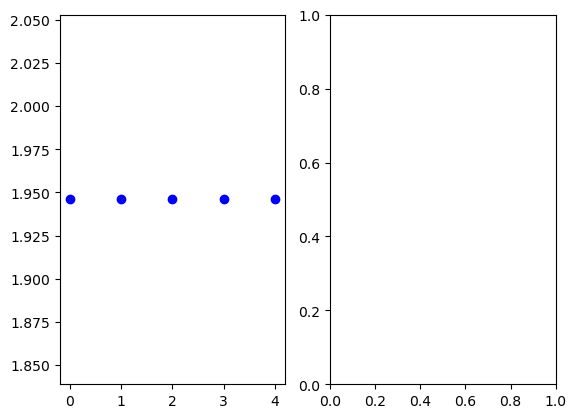

In [157]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
##plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()

In [180]:
'''
#Find the maximum accuracy and its corresponding losses
valAccuracy = np.array(history.history['val_acc'])
trainAccuracy = np.array(history.history['acc'])
valLoss = np.array(history.history['val_loss'])
trainLoss = np.array(history.history['loss'])

epoch0 = np.where(valAccuracy==max(valAccuracy))
print(epoch0)
max_val_acc = valAccuracy[epoch0]
cor_train_acc = trainAccuracy[epoch0] # Train accuracy corresponding to the max val accuracy
cor_val_loss = valLoss[epoch0]
cor_train_loss = trainLoss[epoch0]

print('epoch for max val acc: ', epoch0)
print('max val acc; ', max_val_acc)
print('cor_val_loss: ', cor_val_loss)
print('cor_train_loss: ', cor_train_loss)
print('cor_train_acc: ', cor_train_acc)
'''

KeyError: 'val_acc'

In [181]:
#Evaluate model performance on test dataset
results = MblNetV2_model.evaluate(test_generator)
for i in range(len(MblNetV2_model.metrics_names)):
    print(MblNetV2_model.metrics_names[i], " : ", results[i])

4/4 [==============================] - 97s 21s/step - loss: 1.9459 - acc: 0.1488 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
loss  :  1.9459103345870972
acc  :  0.14878049492835999
top_k_categorical_accuracy  :  1.0
top1_acc  :  1.0
top5_acc  :  1.0
mean_squared_error  :  0.12244898080825806


## Compute performance metrics, e.g. recall and precision

In [ ]:
'''
Y_pred = MblNetV2_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred)
print(res.recall)
print(res.precision)
print(res.f1_score)
print(res.accuracy)
'''

### Use model for prediction and compute the confusion matrix (CM)

4/4 [==============================] - 94s 20s/step
Confusion Matrix
[[61  0  0  0  0  0  0]
 [76  0  0  0  0  0  0]
 [26  0  0  0  0  0  0]
 [62  0  0  0  0  0  0]
 [90  0  0  0  0  0  0]
 [73  0  0  0  0  0  0]
 [22  0  0  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

   cardboard       0.15      1.00      0.26        61
       glass       0.00      0.00      0.00        76
         ied       0.00      0.00      0.00        26
       metal       0.00      0.00      0.00        62
       paper       0.00      0.00      0.00        90
     plastic       0.00      0.00      0.00        73
       trash       0.00      0.00      0.00        22

    accuracy                           0.15       410
   macro avg       0.02      0.14      0.04       410
weighted avg       0.02      0.15      0.04       410



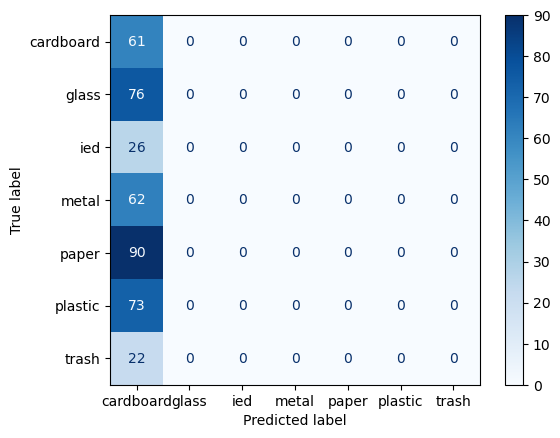

In [182]:
Y_pred = MblNetV2_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## TL 2: Transfer Learning with DenseNet121

In [159]:
# Create the pretrained model as the base model
base_model_DN121 = tf.keras.applications.DenseNet121(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_DN121.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model


In [160]:
##base_model_DN121.summary()

In [161]:
# Add extra layers to the pre-trained base model by function call
DN121_model = new_top_layers(base_model_DN121)

In [162]:
# Find the number of parameters
DN121_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_10 (Flatten)        (None, 50176)             0         
                                                                 
 dense_20 (Dense)            (None, 0)                 0         
                                                                 
 activation_379 (Activation  (None, 0)                 0         
 )                                                               
                                                                 
 dropout_10 (Dropout)        (None, 0)                 0         
                                                                 
 dense_21 (Dense)            (None, 7)                 7         
                                                     

In [163]:
# Compile the model
DN121_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [164]:
#Fit the model to the dataset
DN121_st = time.time() # start the clock
history = DN121_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = validation_generator,
    validation_steps =  validation_steps)

DN121_et = time.time()
DN121_training_time = (DN121_et - DN121_st)/60
print('Model training time in minutes is: ', DN121_training_time)

Epoch 1/5
3/3 [==============================] - 169s 58s/step - loss: 1.9459 - acc: 0.1676
Epoch 2/5
3/3 [==============================] - 142s 42s/step - loss: 1.9459 - acc: 0.1953
Epoch 3/5
3/3 [==============================] - 149s 44s/step - loss: 1.9459 - acc: 0.1667
Epoch 4/5
3/3 [==============================] - 133s 37s/step - loss: 1.9459 - acc: 0.1734
Epoch 5/5
3/3 [==============================] - 145s 43s/step - loss: 1.9459 - acc: 0.1354
Model training time in minutes is:  13.841937434673309


KeyError: 'val_loss'

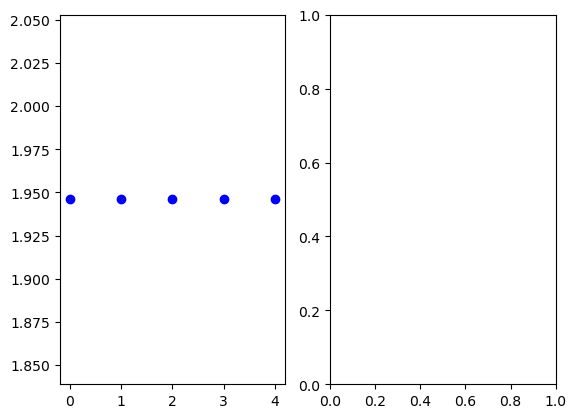

In [165]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
'''
#Find the maximum accuracy and its corresponding losses
valAccuracy = np.array(history.history['val_acc'])
trainAccuracy = np.array(history.history['acc'])
valLoss = np.array(history.history['val_loss'])
trainLoss = np.array(history.history['loss'])

epoch0 = np.where(valAccuracy==max(valAccuracy))
print(epoch0)
max_val_acc = valAccuracy[epoch0]
cor_train_acc = trainAccuracy[epoch0] # Train accuracy corresponding to the max val accuracy
cor_val_loss = valLoss[epoch0]
cor_train_loss = trainLoss[epoch0]

print('epoch for max val acc: ', epoch0)
print('max val acc; ', max_val_acc)
print('cor_val_loss: ', cor_val_loss)
print('cor_train_loss: ', cor_train_loss)
print('cor_train_acc: ', cor_train_acc)
'''

In [183]:
#Evaluate model performance on test dataset
results = DN121_model.evaluate(test_generator)
for i in range(len(DN121_model.metrics_names)):
    print(DN121_model.metrics_names[i], " : ", results[i])

4/4 [==============================] - 146s 28s/step - loss: 1.9459 - acc: 0.1488
loss  :  1.9459103345870972
acc  :  0.14878049492835999


In [ ]:
'''
Y_pred = DN121_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred)
print(res.recall)
print(res.precision)
print(res.f1_score)
print(res.accuracy)
'''

In [ ]:
Y_pred = DN121_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## TL 3: Transfer Learning with NASNetMobile

In [166]:
# Create the pretrained model as the base model
base_model_NNmobile = tf.keras.applications.NASNetMobile(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_NNmobile.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model

In [167]:
# Number of base model parameters
'''
base_model_NNmobile.summary()
'''

'\nbase_model_NNmobile.summary()\n'

In [168]:
# Add extra layers to the pre-trained base model by function call
NNMobile_model = new_top_layers(base_model_NNmobile)

In [169]:
# Find number of model parameters
NNMobile_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 flatten_11 (Flatten)        (None, 51744)             0         
                                                                 
 dense_22 (Dense)            (None, 0)                 0         
                                                                 
 activation_379 (Activation  (None, 0)                 0         
 )                                                               
                                                                 
 dropout_11 (Dropout)        (None, 0)                 0         
                                                                 
 dense_23 (Dense)            (None, 7)                 7         
                                                     

In [170]:
# Compile the model
NNMobile_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [171]:
#Fit the model to the dataset
start_time = time.time() # start the clock

history = NNMobile_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = validation_generator,
    validation_steps =  validation_steps)

end_time = time.time()
training_time = end_time - start_time
print('Model training time in secs is: ', training_time)

Epoch 1/5
3/3 [==============================] - 191s 45s/step - loss: 1.9459 - acc: 0.1536 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 2/5
3/3 [==============================] - 97s 33s/step - loss: 1.9459 - acc: 0.1618 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 3/5
3/3 [==============================] - 103s 31s/step - loss: 1.9459 - acc: 0.1432 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 4/5
3/3 [==============================] - 105s 32s/step - loss: 1.9459 - acc: 0.1562 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 5/5
3/3 [==============================] - 110s 35s/step - loss: 1.9459 - acc: 0.1380 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Model training time i

KeyError: 'val_loss'

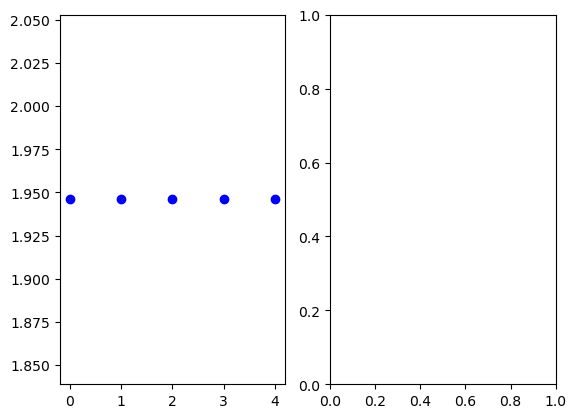

In [172]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
'''
#Find the maximum accuracy and its corresponding losses
valAccuracy = np.array(history.history['val_acc'])
trainAccuracy = np.array(history.history['acc'])
valLoss = np.array(history.history['val_loss'])
trainLoss = np.array(history.history['loss'])

epoch0 = np.where(valAccuracy==max(valAccuracy))
print(epoch0)
max_val_acc = valAccuracy[epoch0]
cor_train_acc = trainAccuracy[epoch0] # Train accuracy corresponding to the max val accuracy
cor_val_loss = valLoss[epoch0]
cor_train_loss = trainLoss[epoch0]

print('epoch for max val acc: ', epoch0)
print('max val acc; ', max_val_acc)
print('cor_val_loss: ', cor_val_loss)
print('cor_train_loss: ', cor_train_loss)
print('cor_train_acc: ', cor_train_acc)
'''

In [184]:
#Evaluate model performance on test dataset
results = NNMobile_model.evaluate(test_generator)
for i in range(len(NNMobile_model.metrics_names)):
    print(NNMobile_model.metrics_names[i], " : ", results[i])

4/4 [==============================] - 112s 21s/step - loss: 1.9459 - acc: 0.1488 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
loss  :  1.9459103345870972
acc  :  0.14878049492835999
top_k_categorical_accuracy  :  1.0
top1_acc  :  1.0
top5_acc  :  1.0
mean_squared_error  :  0.12244898080825806


In [ ]:
'''
Y_pred = NNMobile_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred)
print(res.recall)
print(res.precision)
print(res.f1_score)
print(res.accuracy)
'''

In [ ]:
Y_pred = NNMobile_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## TL 4: Transfer Learning with VGG16-D

In [173]:
# Create the pretrained model as the base model
from tensorflow.keras.applications.vgg16 import VGG16
base_model_vgg16d = VGG16(input_shape=(img_height, img_width, 3), 
                include_top=False, # ideal for feature extraction
                weights='imagenet' )

base_model_vgg16d.trainable = False # Prevent the weights of the base model from being updated before compiling & training the model


In [174]:
# Find number of base model parameters
'''
base_model_vgg16d.summary()
'''

'\nbase_model_vgg16d.summary()\n'

In [175]:
# Add extra layers to the pre-trained base model by function call
vgg16d_model = new_top_layers(base_model_vgg16d)

In [176]:
# Find number of model parameters
vgg16d_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 0)                 0         
                                                                 
 activation_379 (Activation  (None, 0)                 0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 0)                 0         
                                                                 
 dense_25 (Dense)            (None, 7)                 7         
                                                     

In [177]:
# Compile the model
vgg16d_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [178]:
#Fit the model to the dataset
start_time = time.time() # start the clock

history = vgg16d_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    #workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps)

end_time = time.time()
training_time = end_time - start_time
print('Model training time in secs is: ', training_time)

Epoch 1/5
3/3 [==============================] - 378s 137s/step - loss: 1.9459 - acc: 0.1763 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 2/5
3/3 [==============================] - 422s 126s/step - loss: 1.9459 - acc: 0.1406 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 3/5
3/3 [==============================] - 376s 112s/step - loss: 1.9459 - acc: 0.1615 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 4/5
3/3 [==============================] - 363s 112s/step - loss: 1.9459 - acc: 0.1719 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Epoch 5/5
3/3 [==============================] - 361s 128s/step - loss: 1.9459 - acc: 0.1532 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
Model training 

KeyError: 'val_loss'

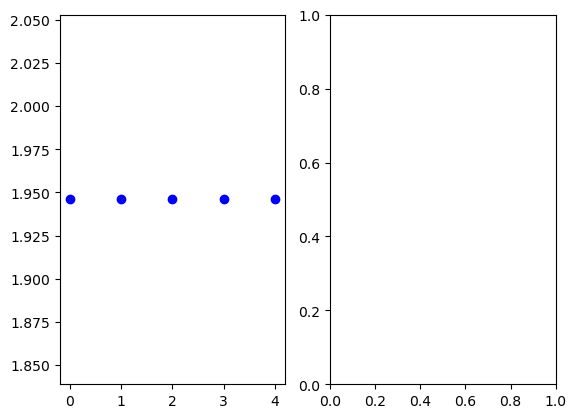

In [179]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(history.history['loss'], 'bo',label='Training Loss')
ax1.plot(history.history['val_loss'], '-r', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
#ax1.set_ylabel('Loss')
plt.savefig('LossVal_loss')

ax2.plot(history.history['acc'], 'bo',label='Training Accuracy')
ax2.plot(history.history['val_acc'], '-r', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
#ax2.set_ylabel('Accuracy')
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
'''
#Find the maximum accuracy and its corresponding losses
valAccuracy = np.array(history.history['val_acc'])
trainAccuracy = np.array(history.history['acc'])
valLoss = np.array(history.history['val_loss'])
trainLoss = np.array(history.history['loss'])

epoch0 = np.where(valAccuracy==max(valAccuracy))
print(epoch0)
max_val_acc = valAccuracy[epoch0]
cor_train_acc = trainAccuracy[epoch0] # Train accuracy corresponding to the max val accuracy
cor_val_loss = valLoss[epoch0]
cor_train_loss = trainLoss[epoch0]

print('epoch for max val acc: ', epoch0)
print('max val acc; ', max_val_acc)
print('cor_val_loss: ', cor_val_loss)
print('cor_train_loss: ', cor_train_loss)
print('cor_train_acc: ', cor_train_acc)
'''

In [185]:
#Evaluate model performance on test dataset
results = vgg16d_model.evaluate(test_generator)
for i in range(len(vgg16d_model.metrics_names)):
    print(vgg16d_model.metrics_names[i], " : ", results[i])

4/4 [==============================] - 410s 87s/step - loss: 1.9459 - acc: 0.1488 - top_k_categorical_accuracy: 1.0000 - top1_acc: 1.0000 - top5_acc: 1.0000 - mean_squared_error: 0.1224
loss  :  1.9459103345870972
acc  :  0.14878049492835999
top_k_categorical_accuracy  :  1.0
top1_acc  :  1.0
top5_acc  :  1.0
mean_squared_error  :  0.12244898080825806


In [ ]:
'''
Y_pred = vgg16d_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
res = classification_performance(test_generator.classes, y_pred)
print(res.recall)
print(res.precision)
print(res.f1_score)
print(res.accuracy)
'''

In [ ]:
Y_pred = vgg16d_model.predict(test_generator,
        len(os.listdir(test_paper))//batchSize + 1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm)

print('Classification Report')
target_names = target_names
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()